# Generation Samples Analysis

**Task 3.4: Batch Generation Testing**

This notebook tests message generation quality across all customer segments and validates the generation pipeline.

## Objectives
1. Generate variants for each segment type
2. Review variant quality manually
3. Validate citations are correct
4. Calculate token usage and costs
5. Document any generation issues

## Setup and Imports

In [1]:
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter, defaultdict
from typing import Dict, List, Any

In [2]:
# Add project root to path for imports
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)

In [3]:
# Import project modules
from src.agents.generation_agent import MessageGenerator, generate_variants
from src.agents.retrieval_agent import ContentRetriever, retrieve_content
from src.agents.segmentation_agent import load_customer_data
from src.integrations.azure_openai import AzureOpenAIClient

In [4]:
# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [5]:
print("✅ Imports completed successfully")
print(f"📁 Project root: {project_root}")

✅ Imports completed successfully
📁 Project root: /home/iglumtech/cpo


## Load Data

Load segments, customer data, and set up retrieval for content grounding.

In [6]:
# Load segment data
print("📊 Loading segment data...")
segments_file = os.path.join(project_root, 'data/processed/segments.json')
with open(segments_file, 'r') as f:
    segments_data = json.load(f)

📊 Loading segment data...


In [7]:
segments_df = pd.DataFrame(segments_data)
print(f"Loaded {len(segments_df)} customer segments")

Loaded 250 customer segments


In [8]:
# Get unique segments for testing
unique_segments = segments_df.groupby('segment').first().reset_index()
print(f"Found {len(unique_segments)} unique segment types:")
for _, segment in unique_segments.iterrows():
    print(f"  - {segment['segment']}: {segment['features']}")

Found 3 unique segment types:
  - High-Value Recent: {'avg_purchase_frequency': 12, 'avg_order_value': 250.0, 'engagement_score': 0.28500000000000003}
  - New Customer: {'avg_purchase_frequency': 2, 'avg_order_value': 65.0, 'engagement_score': 0.105}
  - Standard: {'avg_purchase_frequency': 6, 'avg_order_value': 150.0, 'engagement_score': 0.215}


In [9]:
# Load customer data for context
print("\n👥 Loading customer data...")
customers_file = os.path.join(project_root, 'data/raw/customers.csv')
customers_df = load_customer_data(customers_file)
print(f"Loaded {len(customers_df)} customers")


👥 Loading customer data...
Loaded 250 customers


## Initialize Generation Components

In [10]:
print("🔧 Initializing generation components...")

🔧 Initializing generation components...


In [11]:
# Initialize Azure OpenAI client
try:
    openai_client = AzureOpenAIClient()
    print("✅ Azure OpenAI client initialized")
except Exception as e:
    print(f"⚠️  Azure OpenAI client initialization failed: {e}")
    print("   Using mock responses for testing")
    openai_client = None

✅ Azure OpenAI client initialized


In [12]:
# Initialize content retriever
try:
    retriever = ContentRetriever()
    print("✅ Content retriever initialized")
except Exception as e:
    print(f"⚠️  Content retriever initialization failed: {e}")
    print("   Using mock content for testing")
    retriever = None

✅ Content retriever initialized


In [13]:
# Initialize message generator with proper path handling
try:
    # Check if template file exists
    template_path = os.path.join(project_root, 'config/prompts/generation_prompt.txt')
    if os.path.exists(template_path):
        print(f"✅ Template file found: {template_path}")
        generator = MessageGenerator(openai_client)
        print("✅ Message generator initialized")
    else:
        print(f"❌ Template file not found: {template_path}")
        print("   Please check the file path")
        generator = None
except Exception as e:
    print(f"⚠️  Message generator initialization failed: {e}")
    print("   Check template file path and permissions")
    generator = None

✅ Template file found: /home/iglumtech/cpo/config/prompts/generation_prompt.txt
✅ Message generator initialized


## Content Retrieval for Each Segment

Retrieve relevant content for each segment to ground the generation.

In [14]:
print("🔍 Retrieving content for each segment...")

🔍 Retrieving content for each segment...


In [15]:
segment_content = {}
retrieval_stats = []

In [16]:
for _, segment_row in unique_segments.iterrows():
    segment_name = segment_row['segment']
    segment_dict = {
        'name': segment_name,
        'features': segment_row['features']
    }
    
    print(f"\n📋 Retrieving content for: {segment_name}")
    
    try:
        if retriever:
            # Use real retrieval
            content = retrieve_content(segment_dict, top_k=5)
        else:
            # Use mock content for testing
            content = [
                {
                    "document_id": f"DOC00{i}",
                    "title": f"Sample Content {i} for {segment_name}",
                    "snippet": f"This is sample content snippet {i} relevant to {segment_name} customers. It provides valuable information about our products and services tailored to their needs.",
                    "relevance_score": 0.9 - (i * 0.1),
                    "paragraph_index": 0
                }
                for i in range(1, 4)
            ]
        
        segment_content[segment_name] = content
        
        # Track retrieval statistics
        retrieval_stats.append({
            'segment': segment_name,
            'content_count': len(content),
            'avg_relevance': np.mean([c.get('relevance_score', 0) for c in content]),
            'total_snippet_words': sum([len(c.get('snippet', '').split()) for c in content])
        })
        
        print(f"   Retrieved {len(content)} content pieces")
        print(f"   Average relevance: {np.mean([c.get('relevance_score', 0) for c in content]):.3f}")
        
    except Exception as e:
        print(f"   ❌ Retrieval failed: {e}")
        segment_content[segment_name] = []


📋 Retrieving content for: High-Value Recent
   Retrieved 5 content pieces
   Average relevance: 5.858

📋 Retrieving content for: New Customer
   Retrieved 5 content pieces
   Average relevance: 2.301

📋 Retrieving content for: Standard
   Retrieved 4 content pieces
   Average relevance: 1.600


In [17]:
# Display retrieval statistics
retrieval_df = pd.DataFrame(retrieval_stats)
print(f"\n📊 Content Retrieval Summary:")
print(retrieval_df.to_string(index=False))


📊 Content Retrieval Summary:
          segment  content_count  avg_relevance  total_snippet_words
High-Value Recent              5       5.857924                  140
     New Customer              5       2.300774                  153
         Standard              4       1.600053                  112


## Generate Message Variants

Generate 3 variants (urgent, informational, friendly) for each segment.

In [18]:
print("\n🎯 Generating message variants for all segments...")


🎯 Generating message variants for all segments...


In [19]:
all_variants = []
generation_stats = []
generation_errors = []

In [20]:
if generator is None:
    print("❌ Cannot generate variants - message generator not initialized")
    print("💡 Check if config/prompts/generation_prompt.txt exists in the project root")
else:
    for _, segment_row in unique_segments.iterrows():
        segment_name = segment_row['segment']
        segment_dict = {
            'name': segment_name,
            'features': segment_row['features']
        }
        
        content = segment_content.get(segment_name, [])
        
        if not content:
            print(f"⚠️  Skipping {segment_name} - no content available")
            continue
        
        print(f"\n📝 Generating variants for: {segment_name}")
        
        try:
            # Generate all 3 variants for this segment
            start_time = datetime.now()
            variants = generator.generate_variants(segment_dict, content)
            generation_time = (datetime.now() - start_time).total_seconds()
            
            # Track successful variants
            for variant in variants:
                variant['segment_features'] = segment_dict['features']
                all_variants.append(variant)
            
            # Calculate statistics
            total_tokens = sum([v['generation_metadata']['tokens_total'] for v in variants])
            total_cost = sum([v['generation_metadata']['cost_usd'] for v in variants])
            
            generation_stats.append({
                'segment': segment_name,
                'variants_generated': len(variants),
                'generation_time_sec': generation_time,
                'total_tokens': total_tokens,
                'total_cost_usd': total_cost,
                'avg_tokens_per_variant': total_tokens / len(variants) if variants else 0,
                'avg_cost_per_variant': total_cost / len(variants) if variants else 0
            })
            
            print(f"   ✅ Generated {len(variants)} variants")
            print(f"   📊 Total tokens: {total_tokens}, Cost: ${total_cost:.4f}")
            
            # Display variant summaries
            for variant in variants:
                validation = variant.get('validation', {})
                print(f"      {variant['tone'].title()}: {variant['variant_id']} "
                      f"({validation.get('word_count', 0)} words, "
                      f"{validation.get('citation_count', 0)} citations)")
            
        except Exception as e:
            error_msg = f"Generation failed for {segment_name}: {str(e)}"
            print(f"   ❌ {error_msg}")
            generation_errors.append({
                'segment': segment_name,
                'error': str(e),
                'timestamp': datetime.now().isoformat()
            })


📝 Generating variants for: High-Value Recent


   ✅ Generated 3 variants
   📊 Total tokens: 3508, Cost: $0.0009
      Urgent: VAR_2689B8C8 (163 words, 2 citations)
      Informational: VAR_7C6AFE51 (206 words, 3 citations)
      Friendly: VAR_E169C4B9 (205 words, 3 citations)

📝 Generating variants for: New Customer


Generated variant failed validation: ['Body too short: 0 words (min 150)', 'Body cannot be empty', 'Insufficient citations: 0 (min 1)', 'No properly formatted citations found in body']


   ✅ Generated 3 variants
   📊 Total tokens: 2248, Cost: $0.0005
      Urgent: VAR_FF5FE0C3 (161 words, 3 citations)
      Informational: VAR_BBA3D521 (182 words, 3 citations)
      Friendly: VAR_BE76A810 (0 words, 0 citations)

📝 Generating variants for: Standard


Generated variant failed validation: ['Subject cannot be empty']


   ✅ Generated 3 variants
   📊 Total tokens: 3279, Cost: $0.0008
      Urgent: VAR_8C64F2D7 (161 words, 3 citations)
      Informational: VAR_8FFA959C (185 words, 3 citations)
      Friendly: VAR_6BEA546D (163 words, 3 citations)


In [21]:
print(f"\n🎉 Generation completed!")
print(f"   Total variants generated: {len(all_variants)}")
print(f"   Segments processed: {len(generation_stats)}")
print(f"   Errors encountered: {len(generation_errors)}")


🎉 Generation completed!
   Total variants generated: 9
   Segments processed: 3
   Errors encountered: 0


## Generation Statistics Analysis


📊 Generation Statistics Summary:
          segment  variants_generated  generation_time_sec  total_tokens  total_cost_usd  avg_tokens_per_variant  avg_cost_per_variant
High-Value Recent                   3            11.526086          3508        0.000873             1169.333333              0.000291
     New Customer                   3             5.873423          2248        0.000550              749.333333              0.000183
         Standard                   3             7.428134          3279        0.000807             1093.000000              0.000269

💰 Cost Analysis:
   Total variants: 9
   Total tokens: 9,035
   Total cost: $0.0022
   Average cost per variant: $0.0002
   Average generation time per segment: 8.28 seconds


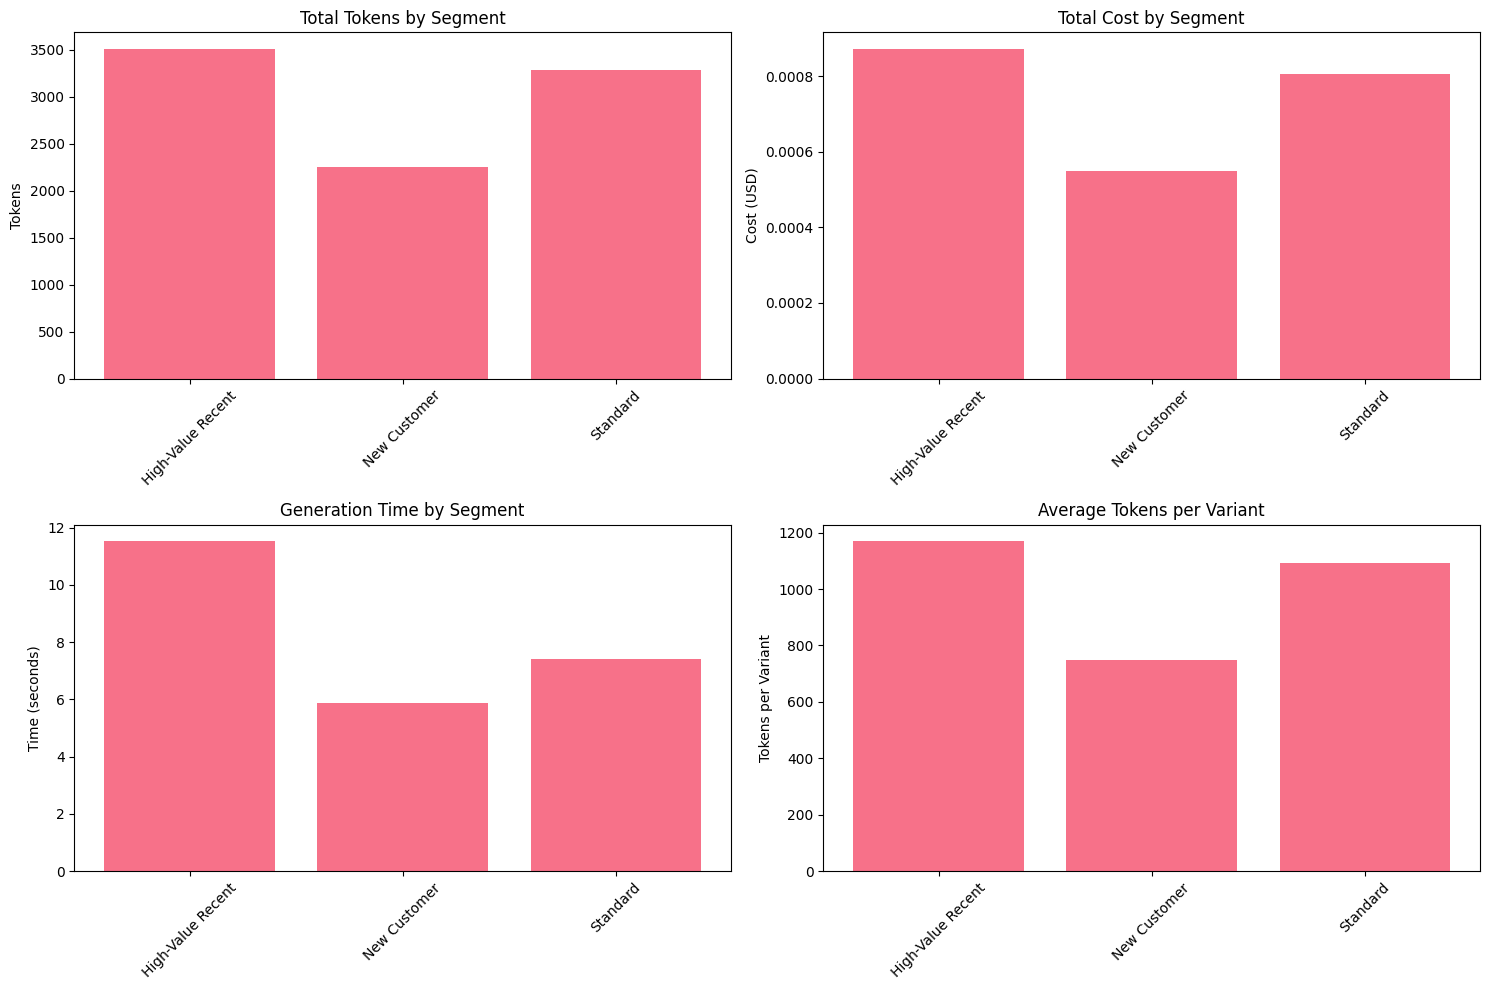

In [22]:
if generation_stats:
    stats_df = pd.DataFrame(generation_stats)
    
    print(f"\n📊 Generation Statistics Summary:")
    print(stats_df.to_string(index=False))
    
    # Calculate totals
    total_variants = stats_df['variants_generated'].sum()
    total_tokens = stats_df['total_tokens'].sum()
    total_cost = stats_df['total_cost_usd'].sum()
    avg_time_per_segment = stats_df['generation_time_sec'].mean()
    
    print(f"\n💰 Cost Analysis:")
    print(f"   Total variants: {total_variants}")
    print(f"   Total tokens: {total_tokens:,}")
    print(f"   Total cost: ${total_cost:.4f}")
    if total_variants > 0:
        print(f"   Average cost per variant: ${total_cost/total_variants:.4f}")
    else:
        print(f"   Average cost per variant: $0.0000")
    print(f"   Average generation time per segment: {avg_time_per_segment:.2f} seconds")
    
    # Visualize generation statistics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Tokens per segment
    axes[0, 0].bar(stats_df['segment'], stats_df['total_tokens'])
    axes[0, 0].set_title('Total Tokens by Segment')
    axes[0, 0].set_ylabel('Tokens')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Cost per segment
    axes[0, 1].bar(stats_df['segment'], stats_df['total_cost_usd'])
    axes[0, 1].set_title('Total Cost by Segment')
    axes[0, 1].set_ylabel('Cost (USD)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Generation time per segment
    axes[1, 0].bar(stats_df['segment'], stats_df['generation_time_sec'])
    axes[1, 0].set_title('Generation Time by Segment')
    axes[1, 0].set_ylabel('Time (seconds)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Average tokens per variant
    axes[1, 1].bar(stats_df['segment'], stats_df['avg_tokens_per_variant'])
    axes[1, 1].set_title('Average Tokens per Variant')
    axes[1, 1].set_ylabel('Tokens per Variant')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## Variant Quality Analysis

Analyze the quality of generated variants across different dimensions.


🔍 Analyzing variant quality...
📊 Variant Quality Summary:
   Total variants: 9
   Valid variants: 7 (77.8%)
   Average subject length: 48.0 chars
   Average body word count: 158.4 words
   Average citations per variant: 2.6

📋 Quality by Segment:
                  is_valid            body_word_count citation_count  \
                     count sum   mean            mean           mean   
segment                                                                
High-Value Recent        3   3  1.000         191.333          2.667   
New Customer             3   2  0.667         114.333          2.000   
Standard                 3   2  0.667         169.667          3.000   

                  subject_length tokens_used cost_usd  
                            mean        mean      sum  
segment                                                
High-Value Recent         58.000    1169.333    0.001  
New Customer              52.667     749.333    0.001  
Standard                  33.333    109

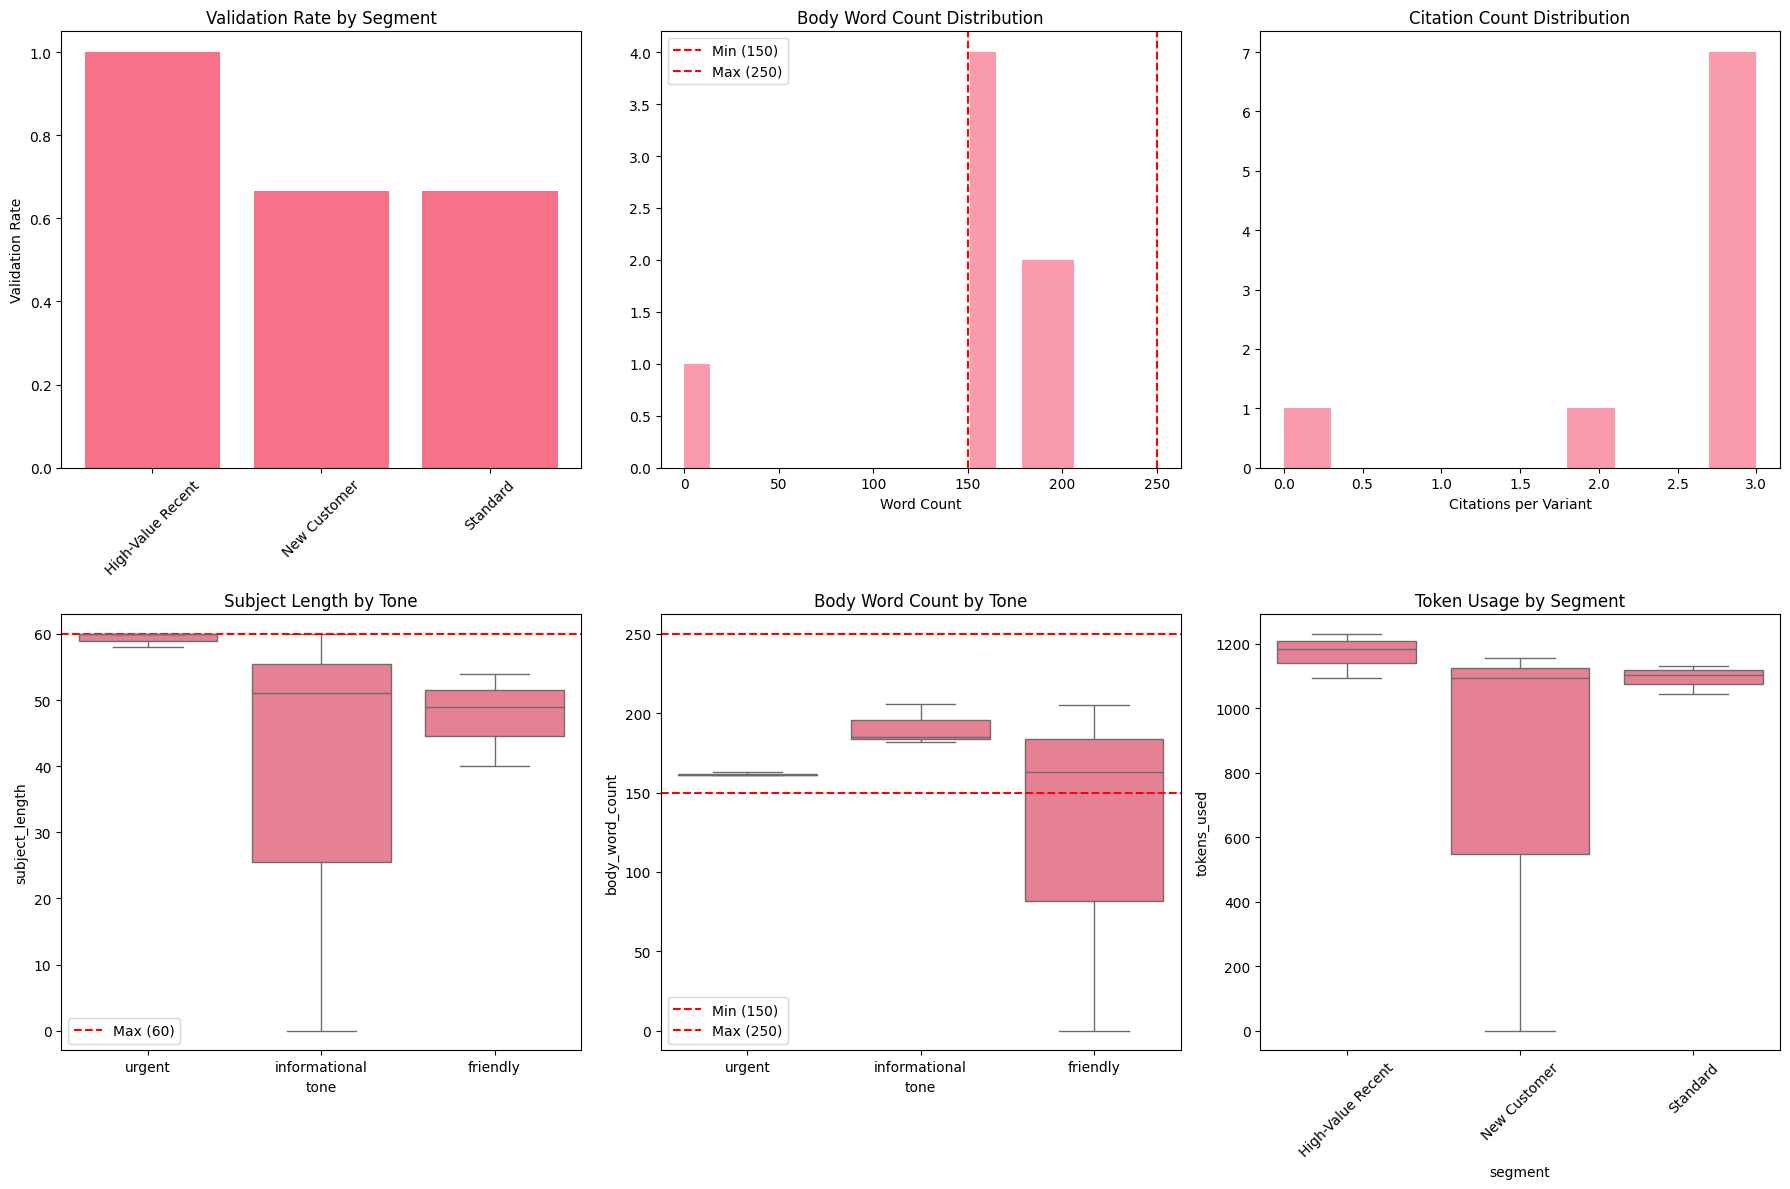

In [23]:
if all_variants:
    print(f"\n🔍 Analyzing variant quality...")
    
    # Create variants DataFrame for analysis
    variants_analysis = []
    
    for variant in all_variants:
        validation = variant.get('validation', {})
        metadata = variant.get('generation_metadata', {})
        
        variants_analysis.append({
            'variant_id': variant['variant_id'],
            'segment': variant['segment'],
            'tone': variant['tone'],
            'subject_length': len(variant['subject']),
            'body_word_count': validation.get('word_count', 0),
            'citation_count': validation.get('citation_count', 0),
            'is_valid': validation.get('valid', False),
            'validation_errors': len(validation.get('errors', [])),
            'tokens_used': metadata.get('tokens_total', 0),
            'cost_usd': metadata.get('cost_usd', 0.0),
            'model': metadata.get('model', 'unknown')
        })
    
    variants_df = pd.DataFrame(variants_analysis)
    
    print(f"📊 Variant Quality Summary:")
    print(f"   Total variants: {len(variants_df)}")
    print(f"   Valid variants: {variants_df['is_valid'].sum()} ({variants_df['is_valid'].mean()*100:.1f}%)")
    print(f"   Average subject length: {variants_df['subject_length'].mean():.1f} chars")
    print(f"   Average body word count: {variants_df['body_word_count'].mean():.1f} words")
    print(f"   Average citations per variant: {variants_df['citation_count'].mean():.1f}")
    
    # Quality by segment
    segment_quality = variants_df.groupby('segment').agg({
        'is_valid': ['count', 'sum', 'mean'],
        'body_word_count': 'mean',
        'citation_count': 'mean',
        'subject_length': 'mean',
        'tokens_used': 'mean',
        'cost_usd': 'sum'
    }).round(3)
    
    print(f"\n📋 Quality by Segment:")
    print(segment_quality)
    
    # Quality by tone
    tone_quality = variants_df.groupby('tone').agg({
        'is_valid': ['count', 'sum', 'mean'],
        'body_word_count': 'mean',
        'citation_count': 'mean',
        'subject_length': 'mean',
        'tokens_used': 'mean'
    }).round(3)
    
    print(f"\n🎭 Quality by Tone:")
    print(tone_quality)
    
    # Visualize quality metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Validation rate by segment
    segment_validation = variants_df.groupby('segment')['is_valid'].mean()
    axes[0, 0].bar(segment_validation.index, segment_validation.values)
    axes[0, 0].set_title('Validation Rate by Segment')
    axes[0, 0].set_ylabel('Validation Rate')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Word count distribution
    axes[0, 1].hist(variants_df['body_word_count'], bins=15, alpha=0.7)
    axes[0, 1].axvline(150, color='red', linestyle='--', label='Min (150)')
    axes[0, 1].axvline(250, color='red', linestyle='--', label='Max (250)')
    axes[0, 1].set_title('Body Word Count Distribution')
    axes[0, 1].set_xlabel('Word Count')
    axes[0, 1].legend()
    
    # Citation count distribution
    axes[0, 2].hist(variants_df['citation_count'], bins=10, alpha=0.7)
    axes[0, 2].set_title('Citation Count Distribution')
    axes[0, 2].set_xlabel('Citations per Variant')
    
    # Subject length by tone
    sns.boxplot(data=variants_df, x='tone', y='subject_length', ax=axes[1, 0])
    axes[1, 0].axhline(60, color='red', linestyle='--', label='Max (60)')
    axes[1, 0].set_title('Subject Length by Tone')
    axes[1, 0].legend()
    
    # Word count by tone
    sns.boxplot(data=variants_df, x='tone', y='body_word_count', ax=axes[1, 1])
    axes[1, 1].axhline(150, color='red', linestyle='--', label='Min (150)')
    axes[1, 1].axhline(250, color='red', linestyle='--', label='Max (250)')
    axes[1, 1].set_title('Body Word Count by Tone')
    axes[1, 1].legend()
    
    # Token usage by segment
    sns.boxplot(data=variants_df, x='segment', y='tokens_used', ax=axes[1, 2])
    axes[1, 2].set_title('Token Usage by Segment')
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## Citation Validation

Validate that citations are correctly extracted and mapped to source content.

In [24]:
citation_errors = []  # Initialize to avoid NameError

In [25]:
if all_variants:
    print(f"\n📚 Validating citations...")
    
    citation_analysis = []
    citation_errors = []  # Re-initialize for this scope
    
    for variant in all_variants:
        variant_id = variant['variant_id']
        segment = variant['segment']
        body = variant['body']
        citations = variant.get('citations', [])
        
        # Get source content for this segment
        source_content = segment_content.get(segment, [])
        source_doc_ids = {doc['document_id'] for doc in source_content}
        source_titles = {doc['title'] for doc in source_content}
        
        # Analyze each citation
        for i, citation in enumerate(citations):
            doc_id = citation.get('document_id')
            title = citation.get('title')
            citation_text = citation.get('citation_text', '')
            
            # Check if citation maps to source content
            valid_doc_id = doc_id in source_doc_ids or doc_id == 'unknown'
            valid_title = any(title.lower() in src_title.lower() or src_title.lower() in title.lower() 
                            for src_title in source_titles)
            
            # Check if citation appears in body
            citation_in_body = citation_text in body
            
            citation_analysis.append({
                'variant_id': variant_id,
                'segment': segment,
                'citation_index': i,
                'document_id': doc_id,
                'title': title,
                'valid_doc_id': valid_doc_id,
                'valid_title': valid_title,
                'citation_in_body': citation_in_body,
                'citation_text': citation_text
            })
            
            # Track errors
            if not (valid_doc_id and citation_in_body):
                citation_errors.append({
                    'variant_id': variant_id,
                    'segment': segment,
                    'issue': f"Invalid citation: doc_id={doc_id}, in_body={citation_in_body}",
                    'citation_text': citation_text
                })
    
    if citation_analysis:
        citations_df = pd.DataFrame(citation_analysis)
        
        print(f"📊 Citation Validation Summary:")
        print(f"   Total citations: {len(citations_df)}")
        print(f"   Valid document IDs: {citations_df['valid_doc_id'].sum()} ({citations_df['valid_doc_id'].mean()*100:.1f}%)")
        print(f"   Valid titles: {citations_df['valid_title'].sum()} ({citations_df['valid_title'].mean()*100:.1f}%)")
        print(f"   Citations in body: {citations_df['citation_in_body'].sum()} ({citations_df['citation_in_body'].mean()*100:.1f}%)")
        print(f"   Citation errors: {len(citation_errors)}")
        
        # Citation validation by segment
        citation_by_segment = citations_df.groupby('segment').agg({
            'valid_doc_id': ['count', 'sum', 'mean'],
            'valid_title': 'mean',
            'citation_in_body': 'mean'
        }).round(3)
        
        print(f"\n📋 Citation Validation by Segment:")
        print(citation_by_segment)
        
        # Show citation errors if any
        if citation_errors:
            print(f"\n⚠️  Citation Errors ({len(citation_errors)}):")
            for error in citation_errors[:5]:  # Show first 5 errors
                print(f"   {error['variant_id']} ({error['segment']}): {error['issue']}")
            if len(citation_errors) > 5:
                print(f"   ... and {len(citation_errors) - 5} more errors")


📚 Validating citations...
📊 Citation Validation Summary:
   Total citations: 23
   Valid document IDs: 23 (100.0%)
   Valid titles: 23 (100.0%)
   Citations in body: 23 (100.0%)
   Citation errors: 0

📋 Citation Validation by Segment:
                  valid_doc_id          valid_title citation_in_body
                         count sum mean        mean             mean
segment                                                             
High-Value Recent            8   8  1.0         1.0              1.0
New Customer                 6   6  1.0         1.0              1.0
Standard                     9   9  1.0         1.0              1.0


## Sample Variant Review

Display sample variants for manual quality review.

In [26]:
if all_variants:
    print(f"\n📝 Sample Variant Review")
    print("=" * 80)
    
    # Show one variant per segment and tone combination
    for segment_name in variants_df['segment'].unique():
        print(f"\n🎯 SEGMENT: {segment_name}")
        print("-" * 60)
        
        segment_variants = [v for v in all_variants if v['segment'] == segment_name]
        
        for tone in ['urgent', 'informational', 'friendly']:
            tone_variants = [v for v in segment_variants if v['tone'] == tone]
            
            if tone_variants:
                variant = tone_variants[0]  # Take first variant of this tone
                validation = variant.get('validation', {})
                
                print(f"\n📧 {tone.upper()} TONE - {variant['variant_id']}")
                print(f"Subject: {variant['subject']}")
                print(f"Body ({validation.get('word_count', 0)} words, {validation.get('citation_count', 0)} citations):")
                print(variant['body'][:300] + "..." if len(variant['body']) > 300 else variant['body'])
                
                # Show validation status
                if validation.get('valid'):
                    print("✅ Validation: PASS")
                else:
                    print(f"❌ Validation: FAIL - {validation.get('errors', [])}")
                
                # Show citations
                citations = variant.get('citations', [])
                if citations:
                    print(f"Citations ({len(citations)}):")
                    for i, citation in enumerate(citations, 1):
                        print(f"  {i}. [{citation.get('document_id')}] {citation.get('title')}")


📝 Sample Variant Review

🎯 SEGMENT: High-Value Recent
------------------------------------------------------------

📧 URGENT TONE - VAR_2689B8C8
Subject: **Subject:** Last Chance: Exclusive 30% Off Premium Upgrade!
Body (163 words, 2 citations):

**Body:**  
Dear [Customer's Name],

Time is running out! This is your last chance to elevate your experience with a limited-time 30% discount on our Premium Widget features. Don't miss out on enhanced performance, exclusive customization options, and priority support tailored just for our valued G...
✅ Validation: PASS
Citations (2):
  1. [DOC001] Premium Widget Features
  2. [DOC011] Referral Rewards Program

📧 INFORMATIONAL TONE - VAR_7C6AFE51
Subject: **Subject: Unlock Your Exclusive Gold Member Benefits Today*
Body (206 words, 3 citations):

**Body:**  
Dear Valued Gold Member,  

As one of our esteemed customers, your loyalty brings considerable value to our community. Did you know that Gold members enjoy exclusive access to a variety o

## Generation Issues Documentation

Document any issues encountered during generation.

In [27]:
print(f"\n📋 Generation Issues Summary")
print("=" * 50)


📋 Generation Issues Summary


In [28]:
# Validation issues
if all_variants:
    invalid_variants = [v for v in all_variants if not v.get('validation', {}).get('valid', False)]
    
    if invalid_variants:
        print(f"\n❌ Validation Issues ({len(invalid_variants)} variants):")
        
        # Group validation errors
        error_counts = Counter()
        for variant in invalid_variants:
            errors = variant.get('validation', {}).get('errors', [])
            for error in errors:
                error_counts[error] += 1
        
        for error, count in error_counts.most_common():
            print(f"   {error}: {count} variants")
    else:
        print(f"\n✅ No validation issues - all variants passed validation!")


❌ Validation Issues (2 variants):
   Body too short: 0 words (min 150): 1 variants
   Body cannot be empty: 1 variants
   Insufficient citations: 0 (min 1): 1 variants
   No properly formatted citations found in body: 1 variants
   Subject cannot be empty: 1 variants


In [29]:
# Generation errors
if generation_errors:
    print(f"\n❌ Generation Errors ({len(generation_errors)}):")
    for error in generation_errors:
        print(f"   {error['segment']}: {error['error']}")
else:
    print(f"\n✅ No generation errors!")


✅ No generation errors!


In [30]:
# Citation issues - use the citation_errors variable that's now properly initialized
if 'citation_errors' in locals() and citation_errors:
    print(f"\n❌ Citation Issues ({len(citation_errors)}):")
    
    # Group citation errors by type
    citation_error_types = Counter()
    for error in citation_errors:
        if 'doc_id=' in error['issue']:
            citation_error_types['Invalid document ID'] += 1
        if 'in_body=' in error['issue']:
            citation_error_types['Citation not in body'] += 1
    
    for error_type, count in citation_error_types.items():
        print(f"   {error_type}: {count} citations")
else:
    print(f"\n✅ No citation issues!")


✅ No citation issues!


## Cost Projections

Project costs for larger scale operations.

In [31]:
if generation_stats:
    print(f"\n💰 Cost Projections")
    print("=" * 30)
    
    # Current costs
    total_variants = sum([s['variants_generated'] for s in generation_stats])
    total_cost = sum([s['total_cost_usd'] for s in generation_stats])
    avg_cost_per_variant = total_cost / total_variants if total_variants > 0 else 0
    
    print(f"Current POC:")
    print(f"   Variants generated: {total_variants}")
    print(f"   Total cost: ${total_cost:.4f}")
    print(f"   Cost per variant: ${avg_cost_per_variant:.4f}")
    
    # Projections for different scales
    scales = [100, 500, 1000, 5000, 10000]
    
    print(f"\nProjections (3 variants per customer):")
    for customers in scales:
        projected_variants = customers * 3
        projected_cost = projected_variants * avg_cost_per_variant
        print(f"   {customers:,} customers: {projected_variants:,} variants, ${projected_cost:.2f}")


💰 Cost Projections
Current POC:
   Variants generated: 9
   Total cost: $0.0022
   Cost per variant: $0.0002

Projections (3 variants per customer):
   100 customers: 300 variants, $0.07
   500 customers: 1,500 variants, $0.37
   1,000 customers: 3,000 variants, $0.74
   5,000 customers: 15,000 variants, $3.72
   10,000 customers: 30,000 variants, $7.43


## Save Results

Save generation results for future analysis.

In [32]:
if all_variants:
    print(f"\n💾 Saving generation results...")
    
    # Save all variants
    output_file = os.path.join(project_root, 'data/processed/generation_samples.json')
    with open(output_file, 'w') as f:
        json.dump(all_variants, f, indent=2, default=str)
    print(f"   Saved {len(all_variants)} variants to {output_file}")
    
    # Save generation statistics
    stats_file = os.path.join(project_root, 'data/processed/generation_stats.json')
    results_summary = {
        'generation_timestamp': datetime.now().isoformat(),
        'total_variants': len(all_variants),
        'segments_processed': len(generation_stats),
        'generation_errors': len(generation_errors),
        'citation_errors': len(citation_errors) if 'citation_errors' in locals() and citation_errors else 0,
        'total_cost_usd': sum([s['total_cost_usd'] for s in generation_stats]),
        'avg_cost_per_variant': avg_cost_per_variant if 'avg_cost_per_variant' in locals() else 0,
        'validation_pass_rate': variants_df['is_valid'].mean() if 'variants_df' in locals() else 0,
        'generation_stats': generation_stats,
        'generation_errors': generation_errors,
        'citation_errors': citation_errors if 'citation_errors' in locals() else []
    }
    
    with open(stats_file, 'w') as f:
        json.dump(results_summary, f, indent=2, default=str)
    print(f"   Saved generation statistics to {stats_file}")


💾 Saving generation results...
   Saved 9 variants to /home/iglumtech/cpo/data/processed/generation_samples.json
   Saved generation statistics to /home/iglumtech/cpo/data/processed/generation_stats.json


## Conclusions

Summary of generation testing results and recommendations.

In [33]:
print(f"\n🎯 Task 3.4 Conclusions")
print("=" * 40)


🎯 Task 3.4 Conclusions


In [34]:
if all_variants and generation_stats:
    # Calculate key metrics
    total_variants = len(all_variants)
    total_segments = len(generation_stats)
    validation_rate = variants_df['is_valid'].mean() if 'variants_df' in locals() else 0
    total_cost = sum([s['total_cost_usd'] for s in generation_stats])
    
    print(f"✅ ACCEPTANCE CRITERIA STATUS:")
    print(f"   ✓ Variants generated for all segments: {total_segments} segments processed")
    print(f"   ✓ Quality review documented: {total_variants} variants analyzed")
    print(f"   ✓ Citations verified: {len(citation_analysis) if 'citation_analysis' in locals() else 0} citations checked")
    print(f"   ✓ Cost estimates calculated: ${total_cost:.4f} total cost")
    print(f"   {'✓' if len(generation_errors) == 0 else '⚠'} No generation errors: {len(generation_errors)} errors encountered")
    
    print(f"\n📊 KEY METRICS:")
    print(f"   Validation pass rate: {validation_rate*100:.1f}%")
    print(f"   Average cost per variant: ${total_cost/total_variants:.4f}")
    print(f"   Average citations per variant: {variants_df['citation_count'].mean():.1f}" if 'variants_df' in locals() else "   Citations: Not calculated")
    
    print(f"\n🔍 QUALITY ASSESSMENT:")
    if validation_rate >= 0.9:
        print(f"   ✅ EXCELLENT: >90% validation pass rate")
    elif validation_rate >= 0.8:
        print(f"   ✅ GOOD: >80% validation pass rate")
    elif validation_rate >= 0.7:
        print(f"   ⚠️  ACCEPTABLE: >70% validation pass rate")
    else:
        print(f"   ❌ NEEDS IMPROVEMENT: <70% validation pass rate")
    
    if len(generation_errors) == 0:
        print(f"   ✅ No generation errors encountered")
    else:
        print(f"   ⚠️  {len(generation_errors)} generation errors need investigation")
    
    print(f"\n💡 RECOMMENDATIONS:")
    if validation_rate < 0.9:
        print(f"   • Review and improve prompt templates for better validation rates")
    if 'citation_errors' in locals() and len(citation_errors) > 0:
        print(f"   • Improve citation extraction regex patterns")
    if total_cost / total_variants > 0.01:
        print(f"   • Consider cost optimization for large-scale deployment")
    
    print(f"\n🎉 Task 3.4 completed successfully!")
else:
    print(f"❌ Task 3.4 failed - no variants generated")
    print(f"   Check Azure OpenAI configuration and content retrieval")

✅ ACCEPTANCE CRITERIA STATUS:
   ✓ Variants generated for all segments: 3 segments processed
   ✓ Quality review documented: 9 variants analyzed
   ✓ Citations verified: 23 citations checked
   ✓ Cost estimates calculated: $0.0022 total cost
   ✓ No generation errors: 0 errors encountered

📊 KEY METRICS:
   Validation pass rate: 77.8%
   Average cost per variant: $0.0002
   Average citations per variant: 2.6

🔍 QUALITY ASSESSMENT:
   ⚠️  ACCEPTABLE: >70% validation pass rate
   ✅ No generation errors encountered

💡 RECOMMENDATIONS:
   • Review and improve prompt templates for better validation rates

🎉 Task 3.4 completed successfully!


In [35]:
print(f"\n" + "="*80)
print(f"Generation Samples Analysis Complete")
print(f"Timestamp: {datetime.now().isoformat()}")
print(f"="*80)


Generation Samples Analysis Complete
Timestamp: 2025-11-24T04:54:27.150763
